# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of the dynamic factor model (DFM) using only 10 topics most highly correlated with GDP growth (out of 200 topics estimated on articles published before 2008 using all sources). I use text data to forecast GDP growth.

## Experiment Details

- **Data Sources:** 10 topics (<=2007, 200 topics, all sources).
- **Forecast Target:** GDP growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Global Factors:** 1 to 2
  - **Factor Order:** 3

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function

# Define inputs common to all models
q_var = 'GDP'                      # quarterly variable being forecasted
additional_factors = None          # or "all" or e.g. ['Labor market'] or 'HardSurveys+Text'
start = '1991-04'
text_type = "topics"
estimation_period = "2007"
num_topics = "200"
source = "all"
with_text = True
only_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
os.makedirs(f"../MSE/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of factors from 1 to 2
for num_factors in range(1, 3):  # Varying number of Global factors: 1, 2
    
    order = 3

    # Define model-specific parameters
    factor_multiplicities = {'Global': num_factors}
    factor_orders = {'Global': order}

    # Prepare lists to store each quarter's forecasts and row labels
    forecasts_all_quarters = []
    row_labels = []

    # Start timing for this model
    start_time = time.time()

    # Loop over each forecast month, get the forecasts, and store the results
    for fm in forecast_months:
        # Use the forecast_month string as the row label
        row_labels.append(fm)

        # Run the forecast function for this quarter
        forecasts_dict = DFM_function.get_forecasts(
            forecast_month = fm,
            q_var = q_var,
            additional_factors = additional_factors,
            factor_multiplicities = factor_multiplicities,
            factor_orders = factor_orders,
            start = start,
            text_type = text_type,
            estimation_period = estimation_period,
            num_topics = num_topics,
            source = source,
            with_text = with_text,
            only_text = only_text
        )

        # Obtain the correct ordering of vintages
        vintages_order = DFM_function.vintage_dates(fm)
        # Extract the forecast value for each vintage in that order
        quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
        forecasts_all_quarters.append(quarter_forecasts)

    # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
    results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)

    # Stop timing for this model and print elapsed time
    elapsed = time.time() - start_time
    elapsed_time = datetime.timedelta(seconds=elapsed)
    print(f"Model with Global factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

    # Construct the output file name
    factors_str = "_".join([
        f"{factor.replace(' ', '_')}_{factor_multiplicities[factor]}_{factor_orders[factor]}"
        for factor in factor_multiplicities])
    file_name = f"forecasts_{q_var}_{factors_str}.csv"

    # Save the CSV file in a subfolder 
    output_path = os.path.join(f"../forecasts/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", file_name)
    results.to_csv(output_path, index=True)

    # ----- MSE Calculation -----
    # Load forecasts
    forecasts = pd.read_csv(output_path, index_col=0)
    # Make sure the index is a column named "date"
    forecasts.index.name = "date"
    forecasts.reset_index(inplace=True)

    # Merge dfs by date 
    merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

    # Calculate the Mean Squared Error (MSE) for each vintage column
    mse_dict = {}
    for col in vintage_col_names:
        mse = ((merged[col] - merged["growth"]) ** 2).mean()
        mse_dict[col] = mse

    # Create a df with one row (the MSE values for each forecasting horizon)
    mse_df = pd.DataFrame(mse_dict, index=[0])

    # Save MSE results to CSV
    mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
    mse_output_path = os.path.join(f"../MSE/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", mse_file_name)
    mse_df.to_csv(mse_output_path, index=False)
    
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-2404.3
EM iteration 50, llf=-2351.1, convergence criterion=7.133e-06
EM iteration 100, llf=-2350.7, convergence criterion=2.1297e-06
EM iteration 150, llf=-2350.5, convergence criterion=1.0552e-06
EM converged at iteration 155, llf=-2350.5, convergence criterion=9.9573e-07 < tolerance=1e-06
EM start iterations, llf=-2404.3
EM iteration 50, llf=-2351.1, convergence criterion=7.133e-06
EM iteration 100, llf=-2350.7, convergence criterion=2.1297e-06
EM iteration 150, llf=-2350.5, convergence criterion=1.0552e-06
EM converged at iteration 155, llf=-2350.5, convergence criterion=9.9573e-07 < tolerance=1e-06
EM start iterations, llf=-2417.1
EM iteration 50, llf=-2363.8, convergence criterion=7.1011e-06
EM iteration 100, llf=-2363.3, convergence criterion=2.1368e-06
EM iteration 150, llf=-2363.2, convergence criterion=1.056e-06
EM converged at iteration 155, llf=-2363.2, convergence criterion=9.9609e-07 < tolerance=1e-06
EM start iterations, llf=-2418.6
EM iteration 

EM start iterations, llf=-2494.7
EM iteration 50, llf=-2441.8, convergence criterion=2.6491e-06
EM converged at iteration 81, llf=-2441.7, convergence criterion=9.9321e-07 < tolerance=1e-06
EM start iterations, llf=-2494.7
EM iteration 50, llf=-2441.8, convergence criterion=2.6491e-06
EM converged at iteration 81, llf=-2441.7, convergence criterion=9.9321e-07 < tolerance=1e-06
EM start iterations, llf=-2494.7
EM iteration 50, llf=-2441.8, convergence criterion=2.6491e-06
EM converged at iteration 81, llf=-2441.7, convergence criterion=9.9321e-07 < tolerance=1e-06
EM start iterations, llf=-2494
EM iteration 50, llf=-2441.3, convergence criterion=2.6665e-06
EM converged at iteration 82, llf=-2441.2, convergence criterion=9.8294e-07 < tolerance=1e-06
EM start iterations, llf=-2485.4
EM iteration 50, llf=-2432.9, convergence criterion=2.629e-06
EM converged at iteration 81, llf=-2432.8, convergence criterion=9.905e-07 < tolerance=1e-06
EM start iterations, llf=-2487.9
EM iteration 50, llf=

EM converged at iteration 92, llf=-2634.1, convergence criterion=9.8491e-07 < tolerance=1e-06
EM start iterations, llf=-2685.6
EM iteration 50, llf=-2634.3, convergence criterion=3.1685e-06
EM converged at iteration 92, llf=-2634.1, convergence criterion=9.8491e-07 < tolerance=1e-06
EM start iterations, llf=-2694.3
EM iteration 50, llf=-2643, convergence criterion=3.15e-06
EM converged at iteration 91, llf=-2642.8, convergence criterion=9.9836e-07 < tolerance=1e-06
EM start iterations, llf=-2695.5
EM iteration 50, llf=-2644.1, convergence criterion=3.5458e-06
EM converged at iteration 98, llf=-2643.8, convergence criterion=9.8749e-07 < tolerance=1e-06
EM start iterations, llf=-2705.1
EM iteration 50, llf=-2653.5, convergence criterion=3.5278e-06
EM converged at iteration 97, llf=-2653.3, convergence criterion=9.9486e-07 < tolerance=1e-06
EM start iterations, llf=-2705.1
EM iteration 50, llf=-2653.5, convergence criterion=3.5278e-06
EM converged at iteration 97, llf=-2653.3, convergence

EM converged at iteration 90, llf=-2837.9, convergence criterion=9.8968e-07 < tolerance=1e-06
EM start iterations, llf=-2890.8
EM iteration 50, llf=-2838.1, convergence criterion=3.2923e-06
EM converged at iteration 90, llf=-2837.9, convergence criterion=9.8968e-07 < tolerance=1e-06
EM start iterations, llf=-2890.8
EM iteration 50, llf=-2838.1, convergence criterion=3.2923e-06
EM converged at iteration 90, llf=-2837.9, convergence criterion=9.8968e-07 < tolerance=1e-06
EM start iterations, llf=-2900.5
EM iteration 50, llf=-2847.5, convergence criterion=3.2471e-06
EM converged at iteration 89, llf=-2847.4, convergence criterion=9.9693e-07 < tolerance=1e-06
EM start iterations, llf=-2901.7
EM iteration 50, llf=-2848.8, convergence criterion=3.2437e-06
EM converged at iteration 89, llf=-2848.6, convergence criterion=9.9286e-07 < tolerance=1e-06
EM start iterations, llf=-2916.7
EM iteration 50, llf=-2863.8, convergence criterion=3.0731e-06
EM converged at iteration 88, llf=-2863.7, converg

EM start iterations, llf=-3119.7
EM iteration 50, llf=-3066.6, convergence criterion=2.5376e-06
EM converged at iteration 79, llf=-3066.5, convergence criterion=9.8351e-07 < tolerance=1e-06
EM start iterations, llf=-3131.1
EM iteration 50, llf=-3077.9, convergence criterion=2.5303e-06
EM converged at iteration 78, llf=-3077.8, convergence criterion=9.9832e-07 < tolerance=1e-06
EM start iterations, llf=-3132.3
EM iteration 50, llf=-3079.1, convergence criterion=2.585e-06
EM converged at iteration 79, llf=-3078.9, convergence criterion=9.933e-07 < tolerance=1e-06
EM start iterations, llf=-3145.3
EM iteration 50, llf=-3092, convergence criterion=2.5894e-06
EM converged at iteration 79, llf=-3091.8, convergence criterion=9.9928e-07 < tolerance=1e-06
EM start iterations, llf=-3145.3
EM iteration 50, llf=-3092, convergence criterion=2.5894e-06
EM converged at iteration 79, llf=-3091.8, convergence criterion=9.9928e-07 < tolerance=1e-06
EM start iterations, llf=-3156.7
EM iteration 50, llf=-3

EM converged at iteration 71, llf=-3286.6, convergence criterion=9.9303e-07 < tolerance=1e-06
EM start iterations, llf=-3342.5
EM iteration 50, llf=-3287.9, convergence criterion=2.1093e-06
EM converged at iteration 71, llf=-3287.8, convergence criterion=9.8926e-07 < tolerance=1e-06
EM start iterations, llf=-3353.7
EM iteration 50, llf=-3299.3, convergence criterion=2.1305e-06
EM converged at iteration 72, llf=-3299.2, convergence criterion=9.738e-07 < tolerance=1e-06
EM start iterations, llf=-3353.7
EM iteration 50, llf=-3299.3, convergence criterion=2.1305e-06
EM converged at iteration 72, llf=-3299.2, convergence criterion=9.738e-07 < tolerance=1e-06
EM start iterations, llf=-3363.5
EM iteration 50, llf=-3309.1, convergence criterion=2.1303e-06
EM converged at iteration 72, llf=-3309, convergence criterion=9.7467e-07 < tolerance=1e-06
EM start iterations, llf=-3363.5
EM iteration 50, llf=-3309.1, convergence criterion=2.1303e-06
EM converged at iteration 72, llf=-3309, convergence c

EM start iterations, llf=-3570.2
EM iteration 50, llf=-3520.1, convergence criterion=2.3766e-06
EM converged at iteration 74, llf=-3520, convergence criterion=9.9604e-07 < tolerance=1e-06
EM start iterations, llf=-3570.2
EM iteration 50, llf=-3520.1, convergence criterion=2.3766e-06
EM converged at iteration 74, llf=-3520, convergence criterion=9.9604e-07 < tolerance=1e-06
EM start iterations, llf=-3581
EM iteration 50, llf=-3531, convergence criterion=2.4118e-06
EM converged at iteration 75, llf=-3530.9, convergence criterion=9.8355e-07 < tolerance=1e-06
EM start iterations, llf=-3581
EM iteration 50, llf=-3531, convergence criterion=2.4118e-06
EM converged at iteration 75, llf=-3530.9, convergence criterion=9.8355e-07 < tolerance=1e-06
EM start iterations, llf=-3581
EM iteration 50, llf=-3531, convergence criterion=2.4118e-06
EM converged at iteration 75, llf=-3530.9, convergence criterion=9.8355e-07 < tolerance=1e-06
EM start iterations, llf=-3591.3
EM iteration 50, llf=-3541.3, con

EM converged at iteration 75, llf=-3734.8, convergence criterion=9.7982e-07 < tolerance=1e-06
EM start iterations, llf=-3798.8
EM iteration 50, llf=-3747.6, convergence criterion=2.4224e-06
EM converged at iteration 74, llf=-3747.4, convergence criterion=9.9785e-07 < tolerance=1e-06
EM start iterations, llf=-3798.8
EM iteration 50, llf=-3747.6, convergence criterion=2.4224e-06
EM converged at iteration 74, llf=-3747.4, convergence criterion=9.9785e-07 < tolerance=1e-06
EM start iterations, llf=-3798.8
EM iteration 50, llf=-3747.6, convergence criterion=2.4224e-06
EM converged at iteration 74, llf=-3747.4, convergence criterion=9.9785e-07 < tolerance=1e-06
EM start iterations, llf=-3809.4
EM iteration 50, llf=-3758.3, convergence criterion=2.4382e-06
EM converged at iteration 75, llf=-3758.1, convergence criterion=9.7071e-07 < tolerance=1e-06
EM start iterations, llf=-3811.1
EM iteration 50, llf=-3760.1, convergence criterion=2.4086e-06
EM converged at iteration 74, llf=-3760, convergen

EM iteration 150, llf=-2425, convergence criterion=1.1487e-06
EM converged at iteration 160, llf=-2425, convergence criterion=9.8794e-07 < tolerance=1e-06
EM start iterations, llf=-2517.4
EM iteration 50, llf=-2427.4, convergence criterion=8.5248e-06
EM iteration 100, llf=-2426.9, convergence criterion=2.2565e-06
EM converged at iteration 139, llf=-2426.8, convergence criterion=9.8768e-07 < tolerance=1e-06
EM start iterations, llf=-2535
EM iteration 50, llf=-2445.1, convergence criterion=9.1102e-06
EM iteration 100, llf=-2444.6, convergence criterion=2.2854e-06
EM converged at iteration 138, llf=-2444.4, convergence criterion=9.9203e-07 < tolerance=1e-06
EM start iterations, llf=-2535
EM iteration 50, llf=-2445.1, convergence criterion=9.1102e-06
EM iteration 100, llf=-2444.6, convergence criterion=2.2854e-06
EM converged at iteration 138, llf=-2444.4, convergence criterion=9.9203e-07 < tolerance=1e-06
EM start iterations, llf=-2549.6
EM iteration 50, llf=-2459.5, convergence criterion

EM start iterations, llf=-2554.5
EM iteration 50, llf=-2464.2, convergence criterion=8.4235e-06
EM iteration 100, llf=-2463.8, convergence criterion=1.1263e-06
EM converged at iteration 104, llf=-2463.8, convergence criterion=9.9298e-07 < tolerance=1e-06
EM start iterations, llf=-2554.5
EM iteration 50, llf=-2464.2, convergence criterion=8.4235e-06
EM iteration 100, llf=-2463.8, convergence criterion=1.1263e-06
EM converged at iteration 104, llf=-2463.8, convergence criterion=9.9298e-07 < tolerance=1e-06
EM start iterations, llf=-2565
EM iteration 50, llf=-2475.1, convergence criterion=8.392e-06
EM iteration 100, llf=-2474.6, convergence criterion=1.0741e-06
EM converged at iteration 103, llf=-2474.6, convergence criterion=9.7729e-07 < tolerance=1e-06
EM start iterations, llf=-2568.3
EM iteration 50, llf=-2478.6, convergence criterion=9.2658e-06
EM iteration 100, llf=-2478.1, convergence criterion=1.341e-06
EM converged at iteration 111, llf=-2478.1, convergence criterion=9.9469e-07 < 

EM iteration 100, llf=-2634.2, convergence criterion=1.3298e-06
EM converged at iteration 112, llf=-2634.2, convergence criterion=9.7999e-07 < tolerance=1e-06
EM start iterations, llf=-2726.7
EM iteration 50, llf=-2634.7, convergence criterion=8.8267e-06
EM iteration 100, llf=-2634.2, convergence criterion=1.3298e-06
EM converged at iteration 112, llf=-2634.2, convergence criterion=9.7999e-07 < tolerance=1e-06
EM start iterations, llf=-2736.2
EM iteration 50, llf=-2644.1, convergence criterion=8.9431e-06
EM iteration 100, llf=-2643.6, convergence criterion=1.338e-06
EM converged at iteration 112, llf=-2643.6, convergence criterion=9.8553e-07 < tolerance=1e-06
EM start iterations, llf=-2736.2
EM iteration 50, llf=-2644.1, convergence criterion=8.9431e-06
EM iteration 100, llf=-2643.6, convergence criterion=1.338e-06
EM converged at iteration 112, llf=-2643.6, convergence criterion=9.8553e-07 < tolerance=1e-06
EM start iterations, llf=-2736.2
EM iteration 50, llf=-2644.1, convergence cri

EM converged at iteration 110, llf=-2776.7, convergence criterion=9.9679e-07 < tolerance=1e-06
EM start iterations, llf=-2885.2
EM iteration 50, llf=-2792.5, convergence criterion=7.6155e-06
EM iteration 100, llf=-2792, convergence criterion=1.2784e-06
EM converged at iteration 110, llf=-2792, convergence criterion=9.9673e-07 < tolerance=1e-06
EM start iterations, llf=-2886.3
EM iteration 50, llf=-2793.5, convergence criterion=7.5942e-06
EM iteration 100, llf=-2793, convergence criterion=1.274e-06
EM converged at iteration 110, llf=-2793, convergence criterion=9.9316e-07 < tolerance=1e-06
EM start iterations, llf=-2901
EM iteration 50, llf=-2807.8, convergence criterion=7.6136e-06
EM iteration 100, llf=-2807.4, convergence criterion=1.2853e-06
EM converged at iteration 111, llf=-2807.3, convergence criterion=9.7937e-07 < tolerance=1e-06
EM start iterations, llf=-2901
EM iteration 50, llf=-2807.8, convergence criterion=7.6136e-06
EM iteration 100, llf=-2807.4, convergence criterion=1.28

EM iteration 50, llf=-2970.4, convergence criterion=7.1933e-06
EM iteration 100, llf=-2970, convergence criterion=1.1693e-06
EM converged at iteration 107, llf=-2970, convergence criterion=9.8733e-07 < tolerance=1e-06
EM start iterations, llf=-3066
EM iteration 50, llf=-2970.4, convergence criterion=7.1933e-06
EM iteration 100, llf=-2970, convergence criterion=1.1693e-06
EM converged at iteration 107, llf=-2970, convergence criterion=9.8733e-07 < tolerance=1e-06
EM start iterations, llf=-3066
EM iteration 50, llf=-2970.4, convergence criterion=7.1933e-06
EM iteration 100, llf=-2970, convergence criterion=1.1693e-06
EM converged at iteration 107, llf=-2970, convergence criterion=9.8733e-07 < tolerance=1e-06
EM start iterations, llf=-3078.2
EM iteration 50, llf=-2982.4, convergence criterion=7.3399e-06
EM iteration 100, llf=-2982, convergence criterion=1.2005e-06
EM converged at iteration 108, llf=-2982, convergence criterion=9.8977e-07 < tolerance=1e-06
EM start iterations, llf=-3079.5


EM converged at iteration 106, llf=-3130.8, convergence criterion=9.7711e-07 < tolerance=1e-06
EM start iterations, llf=-3239.1
EM iteration 50, llf=-3141, convergence criterion=6.8133e-06
EM iteration 100, llf=-3140.5, convergence criterion=1.1624e-06
EM converged at iteration 107, llf=-3140.5, convergence criterion=9.7725e-07 < tolerance=1e-06
EM start iterations, llf=-3239.1
EM iteration 50, llf=-3141, convergence criterion=6.8133e-06
EM iteration 100, llf=-3140.5, convergence criterion=1.1624e-06
EM converged at iteration 107, llf=-3140.5, convergence criterion=9.7725e-07 < tolerance=1e-06
EM start iterations, llf=-3250.2
EM iteration 50, llf=-3152.1, convergence criterion=6.7402e-06
EM iteration 100, llf=-3151.6, convergence criterion=1.1459e-06
EM converged at iteration 106, llf=-3151.6, convergence criterion=9.8735e-07 < tolerance=1e-06
EM start iterations, llf=-3250.2
EM iteration 50, llf=-3152.1, convergence criterion=6.7402e-06
EM iteration 100, llf=-3151.6, convergence crite

EM start iterations, llf=-3420.6
EM iteration 50, llf=-3318.5, convergence criterion=6.7616e-06
EM iteration 100, llf=-3318, convergence criterion=1.2179e-06
EM converged at iteration 109, llf=-3318, convergence criterion=9.7897e-07 < tolerance=1e-06
EM start iterations, llf=-3420.6
EM iteration 50, llf=-3318.5, convergence criterion=6.7616e-06
EM iteration 100, llf=-3318, convergence criterion=1.2179e-06
EM converged at iteration 109, llf=-3318, convergence criterion=9.7897e-07 < tolerance=1e-06
EM start iterations, llf=-3431.5
EM iteration 50, llf=-3331.6, convergence criterion=7.0481e-06
EM iteration 100, llf=-3331.1, convergence criterion=1.2792e-06
EM converged at iteration 111, llf=-3331, convergence criterion=9.8391e-07 < tolerance=1e-06
EM start iterations, llf=-3431.5
EM iteration 50, llf=-3331.6, convergence criterion=7.0481e-06
EM iteration 100, llf=-3331.1, convergence criterion=1.2792e-06
EM converged at iteration 111, llf=-3331, convergence criterion=9.8391e-07 < toleranc

EM iteration 100, llf=-3472.5, convergence criterion=1.8546e-06
EM converged at iteration 129, llf=-3472.4, convergence criterion=9.9896e-07 < tolerance=1e-06
EM start iterations, llf=-3583
EM iteration 50, llf=-3484.4, convergence criterion=7.8079e-06
EM iteration 100, llf=-3483.7, convergence criterion=1.7636e-06
EM converged at iteration 128, llf=-3483.6, convergence criterion=9.8286e-07 < tolerance=1e-06
EM start iterations, llf=-3584.2
EM iteration 50, llf=-3485.6, convergence criterion=7.8031e-06
EM iteration 100, llf=-3484.9, convergence criterion=1.7637e-06
EM converged at iteration 128, llf=-3484.8, convergence criterion=9.8297e-07 < tolerance=1e-06
EM start iterations, llf=-3601.1
EM iteration 50, llf=-3502.5, convergence criterion=7.846e-06
EM iteration 100, llf=-3501.9, convergence criterion=1.7226e-06
EM converged at iteration 126, llf=-3501.7, convergence criterion=9.9708e-07 < tolerance=1e-06
EM start iterations, llf=-3601.1
EM iteration 50, llf=-3502.5, convergence crit

EM start iterations, llf=-3753.9
EM iteration 50, llf=-3653.2, convergence criterion=7.896e-06
EM iteration 100, llf=-3652.5, convergence criterion=1.6872e-06
EM converged at iteration 125, llf=-3652.4, convergence criterion=9.8728e-07 < tolerance=1e-06
EM start iterations, llf=-3753.9
EM iteration 50, llf=-3653.2, convergence criterion=7.896e-06
EM iteration 100, llf=-3652.5, convergence criterion=1.6872e-06
EM converged at iteration 125, llf=-3652.4, convergence criterion=9.8728e-07 < tolerance=1e-06
EM start iterations, llf=-3753.9
EM iteration 50, llf=-3653.2, convergence criterion=7.896e-06
EM iteration 100, llf=-3652.5, convergence criterion=1.6872e-06
EM converged at iteration 125, llf=-3652.4, convergence criterion=9.8728e-07 < tolerance=1e-06
EM start iterations, llf=-3766.7
EM iteration 50, llf=-3665.8, convergence criterion=7.8183e-06
EM iteration 100, llf=-3665.1, convergence criterion=1.6887e-06
EM converged at iteration 125, llf=-3665, convergence criterion=9.9013e-07 < t

Plot MSE values for the models with 1 or 2 Global factors evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


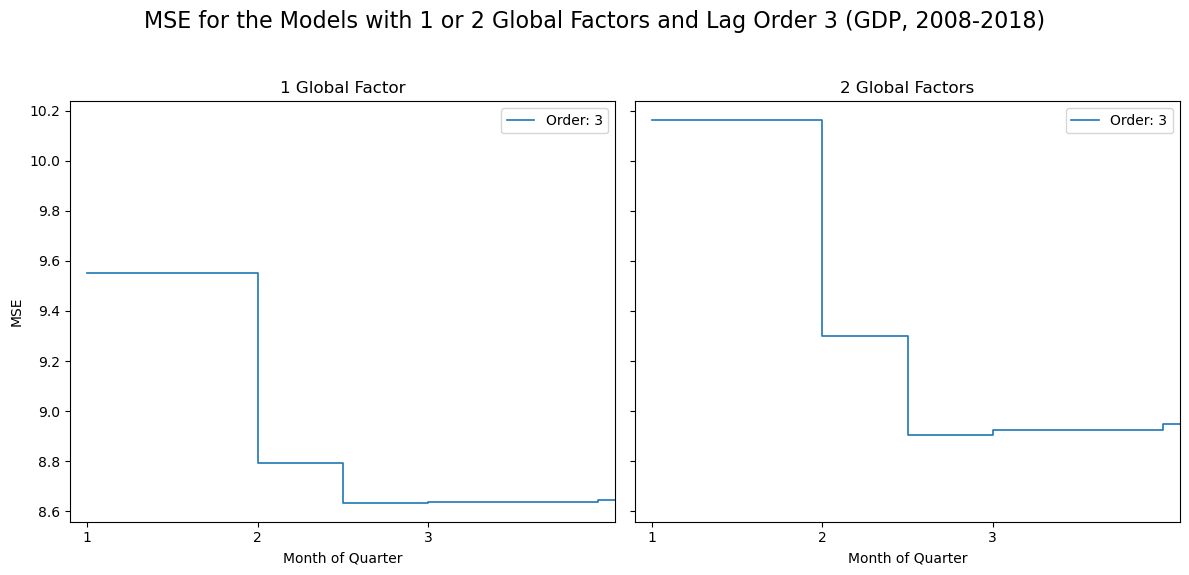

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'GDP'
text_type = "topics"
estimation_period = "2007"
num_topics = "200"
source = "all"

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}"

# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Loop over each number of global factors (1 and 2)
for i, num_factors in enumerate(range(1, 3)):
    ax = axs[i]
    
    order = 3

    # Construct file name based on the model's parameters
    factors_str = f"Global_{num_factors}_{order}"
    mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
    mse_file_path = os.path.join(mse_dir, mse_file_name)

    # Load the MSE values from file
    mse_df = pd.read_csv(mse_file_path)
    # Construct y values based on the vintages
    y_values = [mse_df[col].iloc[0] for col in vintage_col_names]

    # Extend the y-values so the step function holds the last value
    y_extended = y_values.copy()
    y_extended.append(y_values[-1]) # Repeat the last value

    # Plot the step function for the current model
    ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
             label=f"Order: {order}")

    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for the Models with 1 or 2 Global Factors and Lag Order 3 ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", f"DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png", bbox_inches="tight")
plt.savefig(f"{base_filename}.eps", format="eps", bbox_inches="tight")

plt.show()

Plot MSE values for the models with 1 or 2 Global Factors and Lag Order 3 evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


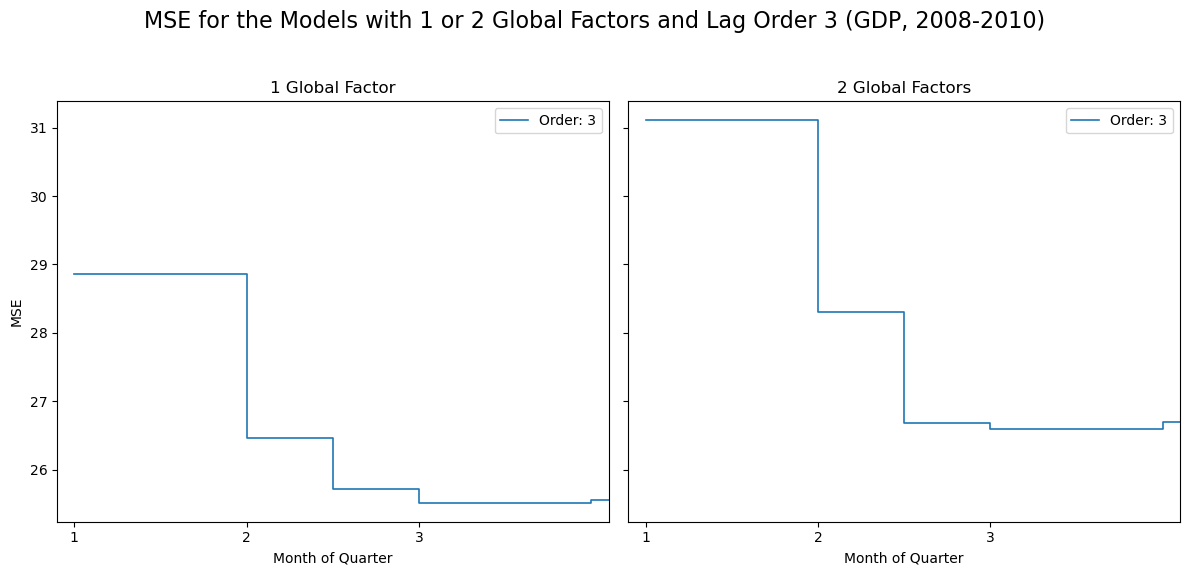

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


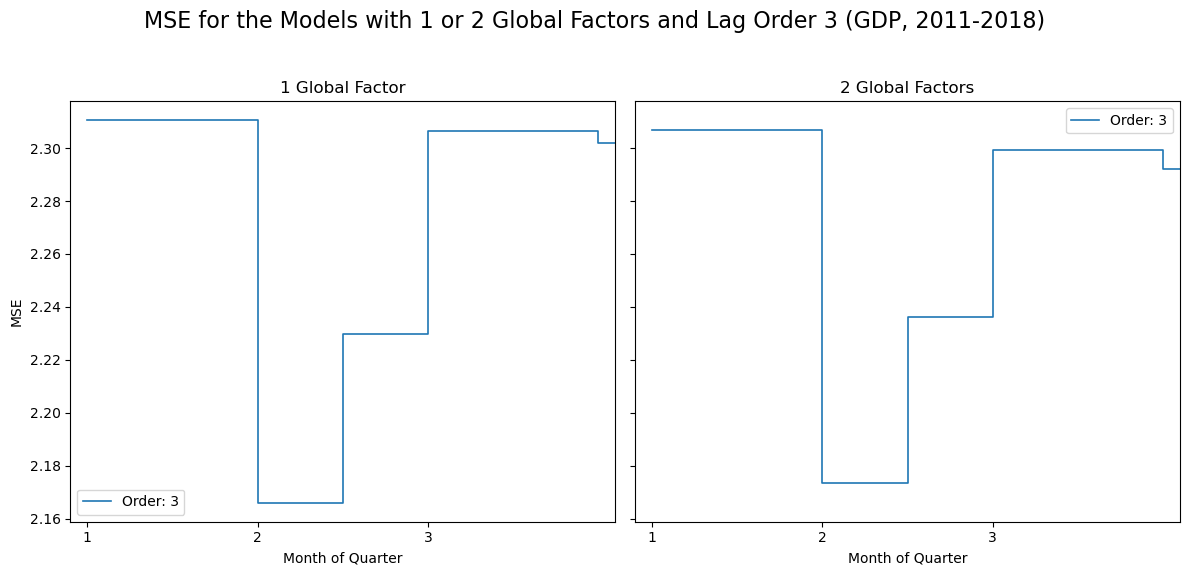

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'GDP'
text_type = "topics"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 2 columns of subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    # Loop over each number of global factors (1 and 2)
    for i, num_factors in enumerate(range(1, 3)):
        ax = axs[i]
        
        order = 3

        # Construct forecast file name, e.g., "forecasts_GDP_Global_1_1.csv"
        factors_str = f"Global_{num_factors}_{order}"
        forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
        forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

        # Load forecast data 
        forecasts = pd.read_csv(forecast_file_path, index_col=0)
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge forecasts with actual growth 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
        merged["date_float"] = merged["date"].apply(quarter_to_float)
        merged.sort_values("date_float", inplace=True)

        # Filter merged data for the current period
        merged_period = merged[ period_filter(merged) ]

        # Calculate MSE for each vintage column over the filtered period
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Construct y values based on the vintages
        y_values = [mse_dict[col] for col in vintage_col_names]

        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value

        # Plot the step function for the current model (order)
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                label=f"Order: {order}")

        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for the Models with 1 or 2 Global Factors and Lag Order 3 ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", f"DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png", bbox_inches="tight")
    plt.savefig(f"{base_filename}.eps", format="eps", bbox_inches="tight")

    plt.show()

Plot forecasts vs actual growth values for the models with 1 or 2 Global Factors, Lag Order 3 and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


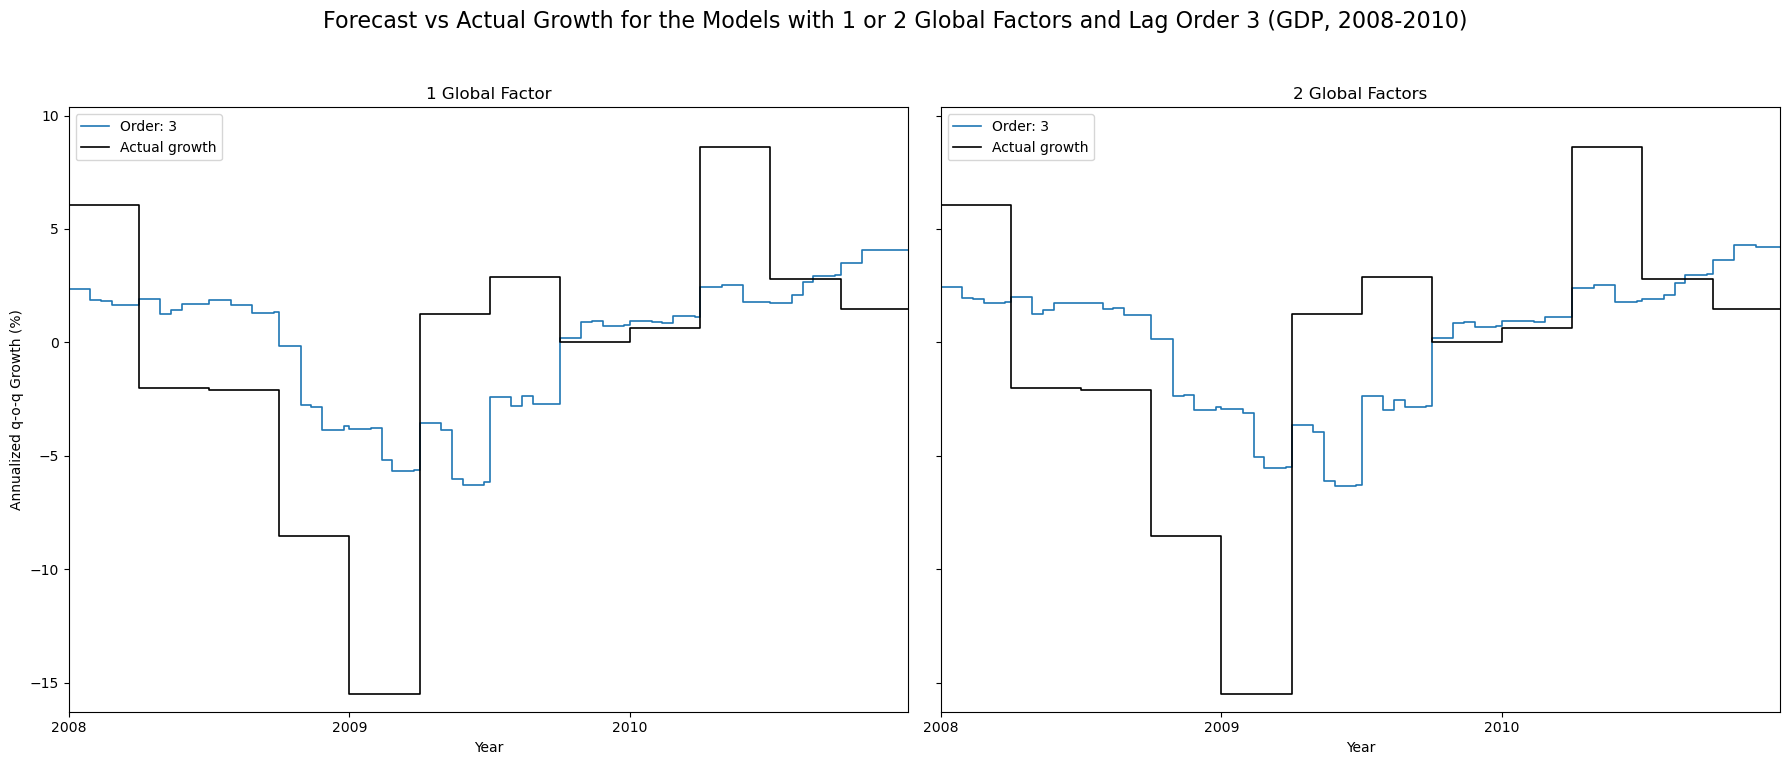

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


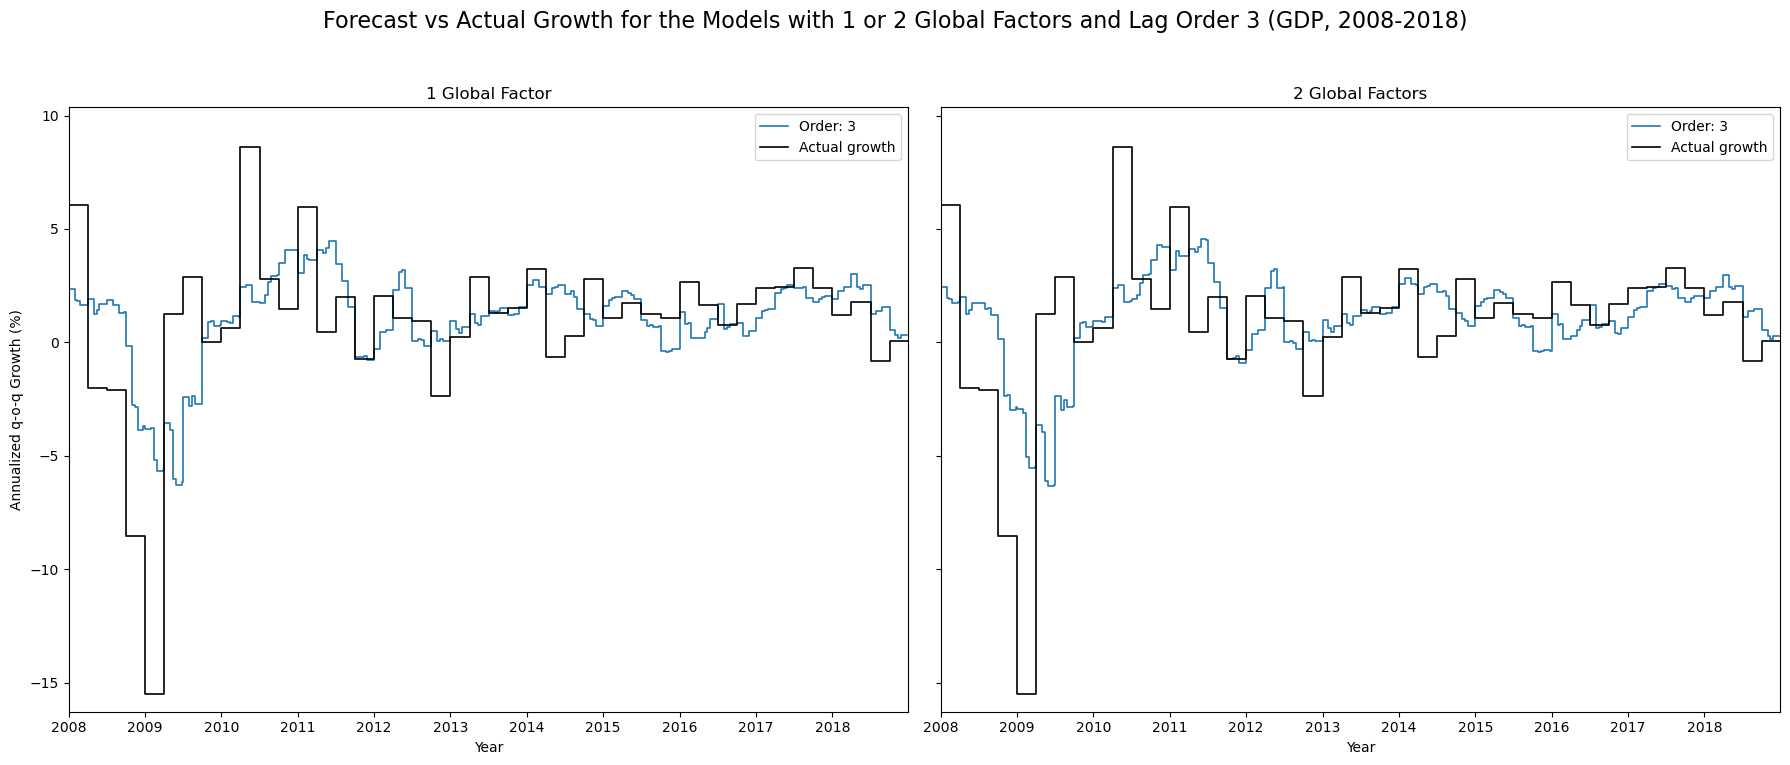

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


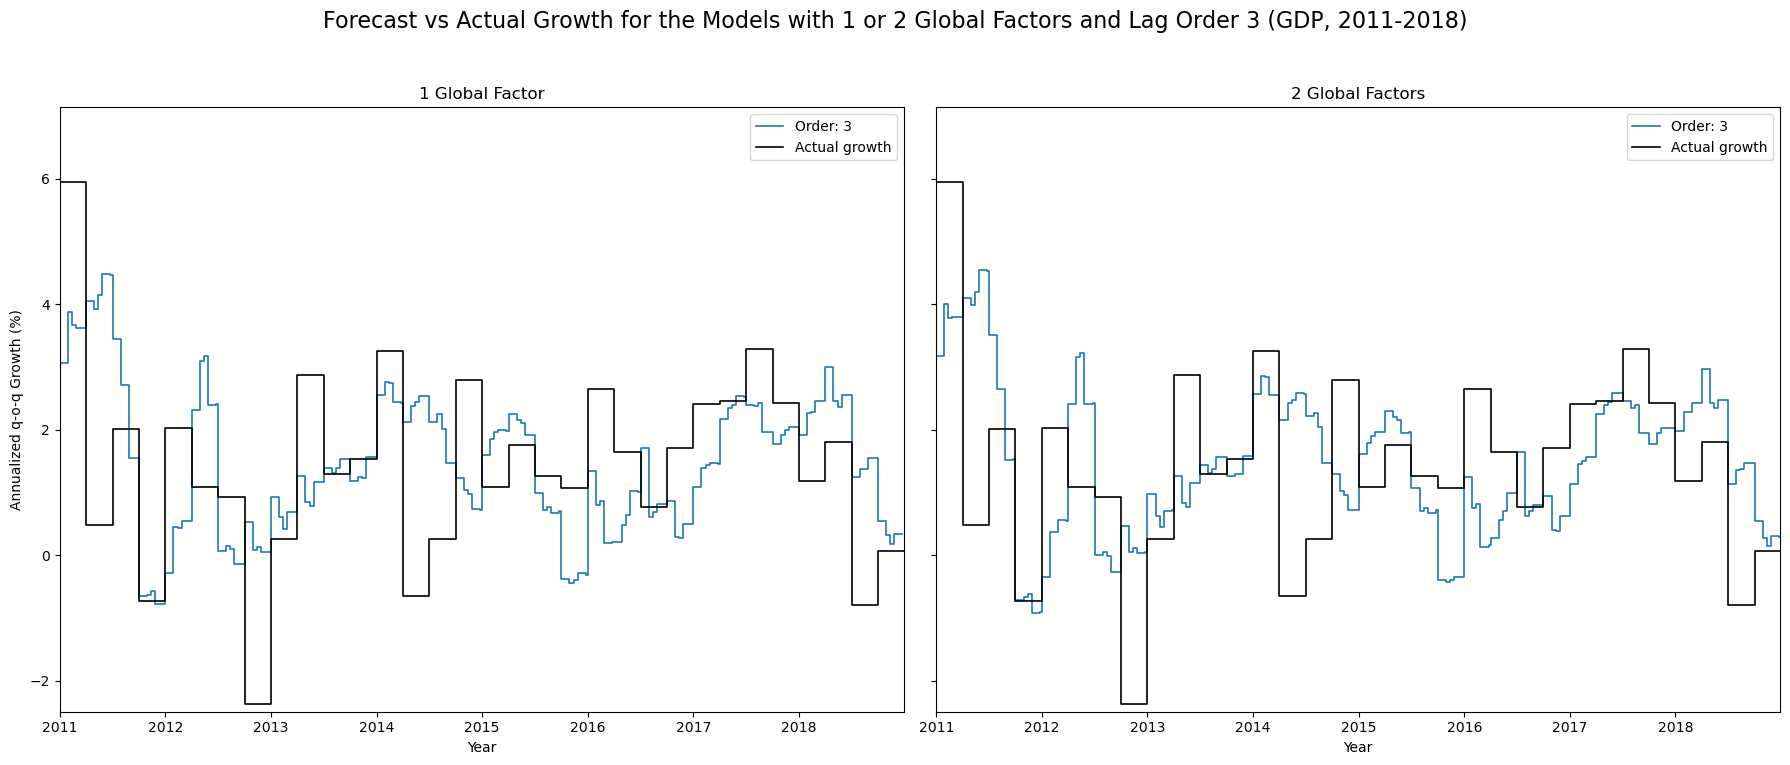

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'GDP'
text_type = "topics"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 2 columns for the three global factor counts
    fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharey=True)
    
    # Loop over each global factor count (1 and 2)
    for i, num_factors in enumerate([1, 2]):
        ax = axs[i]

        order = 3

        # Construct forecast file name, e.g., "forecasts_GDP_Global_1_1.csv"
        factors_str = f"Global_{num_factors}_{order}"
        forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
        forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

        # Load forecast data 
        forecasts = pd.read_csv(forecast_file_path, index_col=0)
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge forecasts with actual growth dates
        merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
        merged["date_float"] = merged["date"].apply(quarter_to_float)
        merged.sort_values("date_float", inplace=True)

        # Build forecast x and y arrays 
        x_fore = []
        y_fore = []
        for idx, row in merged.iterrows():
            base_x = row["date_float"]
            # For each of the 7 vintage columns, define an x-position and take that forecast value
            for j, col in enumerate(vintage_col_names):
                x_fore.append(base_x + offsets[j])
                y_fore.append(row[col])

        # Plot the forecast step curve for the current order
        ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])

        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)

        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))

        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for the Models with 1 or 2 Global Factors and Lag Order 3 ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", f"DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png", bbox_inches="tight")
    plt.savefig(f"{base_filename}.eps", format="eps", bbox_inches="tight")

    plt.show()